# Spotify EDA
EDA Queries and Charts

In [2]:
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format ='retina'

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import json
import seaborn as sns
import time
import random

from sqlalchemy.ext.declarative import declarative_base 
from sqlalchemy import Table, Column, Integer, String, MetaData, and_, or_, func,distinct

%matplotlib inline

In [4]:
import importlib

sys.path.append('../')
from spotify_api import get_spotify_data, get_tracks, get_artists, get_audiofeatures
from spotify_database import get_session, display_time
from spotify_utils import Table_Generator, List_Generator, pickle_load, pickle_save

In [5]:
# from tqdm import tqdm_notebook as tqdm
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [6]:
# # Setup Pyton Variables in Markdown

# # https://github.com/ipython-contrib/jupyter_contrib_nbextensions
# !pip install jupyter_contrib_nbextensions

# # install javascript and css files
# !jupyter contrib nbextension install --user

# # There are many extensions available
# # https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/
# !jupyter nbextension enable python-markdown/main

# # NOTE: The notebook needs to be trusted!  See button on top-right of page

## Spotify API
You will need to setup a Spotify API developer account and store your credentials in local environment variables for these functions to work.

SPOTIFY_CLIENT_ID<br>
SPOTIFY_CLIENT_SECRET<br>
SPOTIFY_REDIRECT_URI<br>
<br>
template bash profile lines:<br>
export SPOTIFY_CLIENT_ID={your info here} <br>
export SPOTIFY_CLIENT_SECRET={your info here} <br>
export SPOTIFY_REDIRECT_URI=cs109arecommender://callback <br>

You will need to reload your bash profile and possibly restart your jupyter server.  


## SQL Lite DataBase

Provide path of static dataset database 

Get session from database module

Get the SQLalchemy Classes from session method

## Set database path on local drive

In [7]:
db_path = '../data/SpotifyDataSet/spotify_songs.db'

In [8]:
# Get sesion
session = get_session(db_path)

In [9]:
# Get Classes
Playlists = getattr(get_session, "Playlists")
Artists = getattr(get_session, "Artists")
Tracks = getattr(get_session, "Tracks")

### Test DB and Spotify Connections

In [10]:
# Spotify 
result = display_time(session.query(Tracks).first)
result.track_uri

Time to Execute: 0.13 seconds


'spotify:track:2d7LPtieXdIYzf7yHPooWd'

In [11]:
# Database
test_rv = display_time(session.query(Artists).first)
test_rv.artist_name

Time to Execute: 0.03 seconds


"Jane's Addiction with Body Count"

### Basic Counts

In [12]:

num_tracks        = display_time(session.query(Tracks.track_uri).count)
num_artists       = display_time(session.query(Artists.artist_name).count)
num_playlists     = display_time(session.query(Playlists.playlist_id).distinct().count)

print("Number of unique tracks in db:    {:,}".format(num_tracks))
print("Number of unique artists in db:   {:,}".format(num_artists))
print("Number of unique playlists in db: {:,}".format(num_playlists))

Time to Execute: 180.54 seconds
Time to Execute: 1.9 seconds
Time to Execute: 393.63 seconds
Number of unique tracks in db:    2,261,597
Number of unique artists in db:   296,014
Number of unique playlists in db: 999,001


### Playlists
Create histogram of number of songs in playlists

In [13]:
# Count Number of tracks in playlists
songs_per_playlist = display_time(session.query(Playlists.playlist_id, 
                                func.count(Playlists.track_name).label('count')).group_by(Playlists.playlist_id).all)

# Do subsequent grouping in dataframe
df_counts = pd.DataFrame(data=songs_per_playlist, 
                         columns=["playlist_id","song_count"])

df_counts_agg = df_counts.groupby(['song_count']).agg({'playlist_id':'count'})

len(df_counts_agg) # number of playlist lengths

Time to Execute: 174.7 seconds


309

In [14]:
print ("Mean number of songs per playlist  : {}".format(round(np.mean(df_counts.song_count), 2)))
print ("Median number of songs per playlist: {}".format(round(np.median(df_counts.song_count), 2)))

print ("Minimum playlist length: {}".format(np.min(df_counts.song_count)))
print ("Maximum playlist length: {}".format(np.max(df_counts.song_count)))


Mean number of songs per playlist  : 66.41
Median number of songs per playlist: 49.0
Minimum playlist length: 4
Maximum playlist length: 459


In [15]:
df_counts.describe()

,playlist_id,song_count
count,999001.000000,999001.000000
mean,499501.000000,66.410792
std,288386.892471,53.737745
min,1.000000,4.000000
25%,249751.000000,26.000000
50%,499501.000000,49.000000
75%,749251.000000,92.000000
max,999001.000000,459.000000


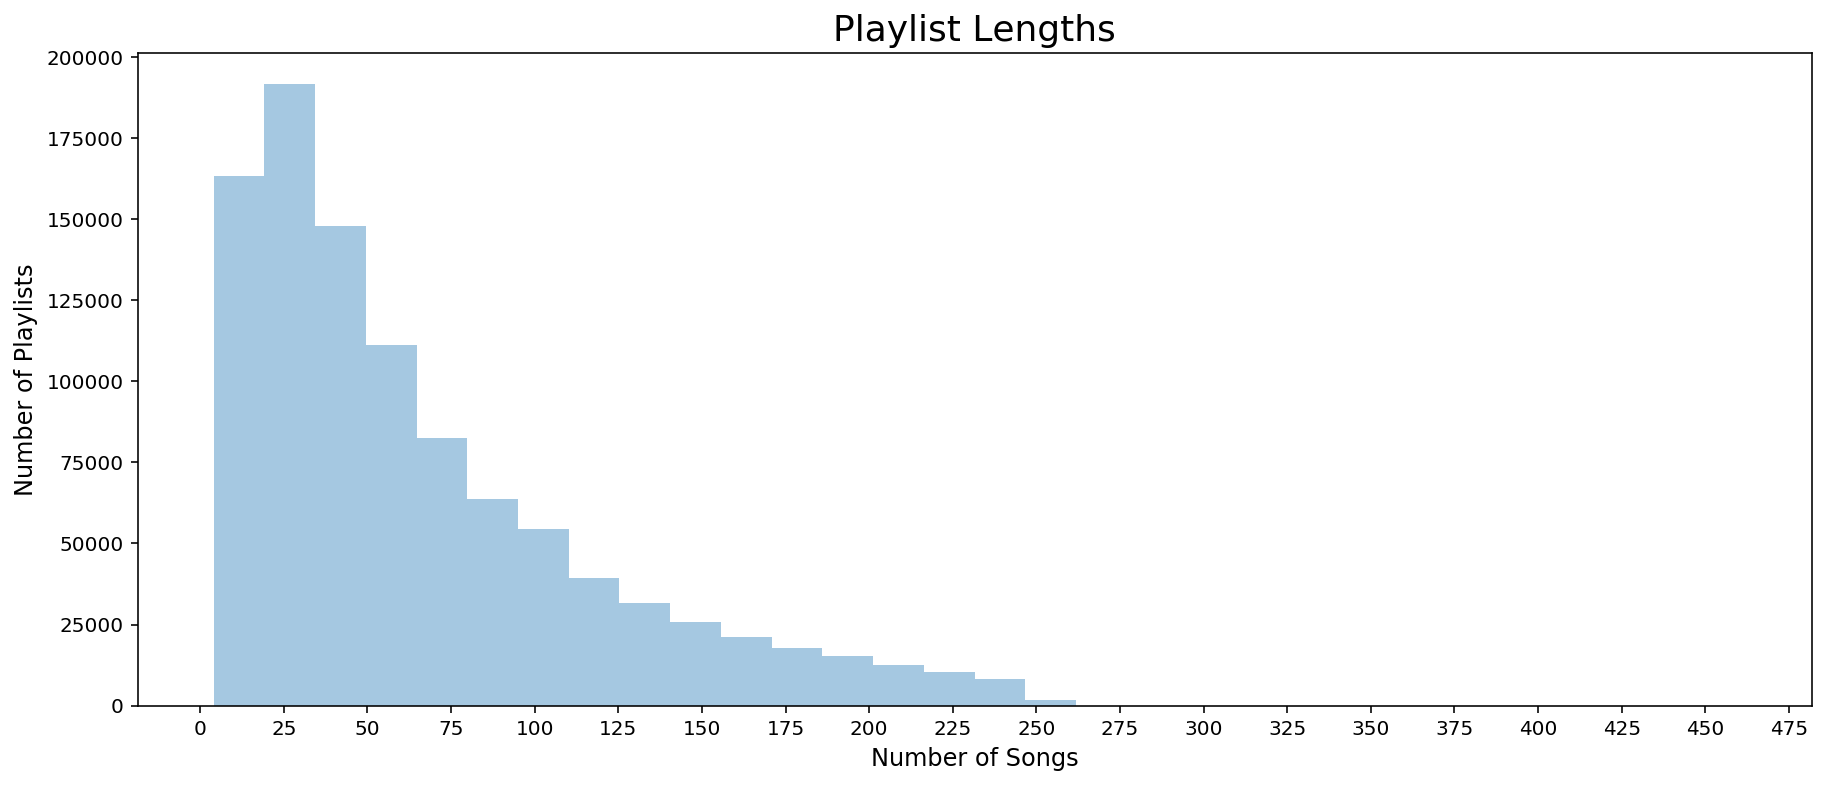

In [16]:
# Plot playlist length distribution
fig, subplot = plt.subplots(figsize=(15,6))
subplot.set_title("Playlist Lengths", fontsize=18)
sns.distplot(df_counts.song_count, bins=30, ax=subplot, kde=False);
subplot.set_xlabel("Number of Songs", fontsize=12)
subplot.set_ylabel("Number of Playlists", fontsize=12);

start, end = subplot.get_xlim()
subplot.xaxis.set_ticks(np.arange(0, end, 25))
fig.show()

## Artists

In [17]:
# Artist Popularity - measured by number of appearances
artist_playlist_count = display_time(session.query(Playlists.artist_name, func.count(Playlists.artist_name).label('count')).group_by(Playlists.artist_name).all)
df_artist_popularity = pd.DataFrame(artist_playlist_count).sort_values(by="count", ascending=False).reset_index(drop=True)
df_artist_popularity1 = df_artist_popularity.set_index(['artist_name'])

cols=['artist_name','count']
top20 = df_artist_popularity1[0:20]


Time to Execute: 201.12 seconds


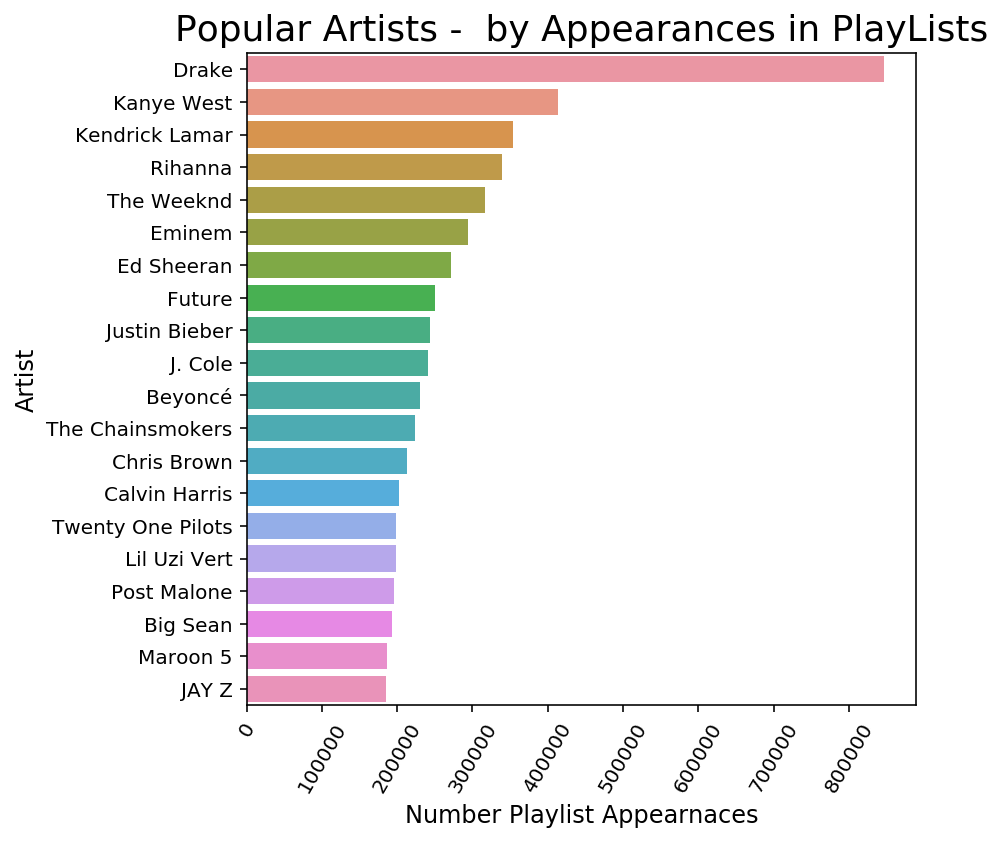

In [18]:
# Plot popular artists
fig, subplot = plt.subplots(figsize=(6,6))
subplot.set_title("Popular Artists -  by Appearances in PlayLists", fontsize=18)
sns.barplot(y=top20.index,
            x=top20['count'],
            orient="h", ax=subplot)
subplot.set_xlabel("Number Playlist Appearnaces", fontsize=12)
subplot.set_ylabel("Artist", fontsize=12);
subplot.tick_params(axis='x', labelrotation=60);

In [19]:
df_artist_popularity1.describe()

,count
count,287688.000000
mean,230.612459
std,3868.568138
min,0.000000
25%,1.000000
50%,3.000000
75%,13.000000
max,847159.000000


In [20]:
np.median(df_artist_popularity1['count'])

3.0

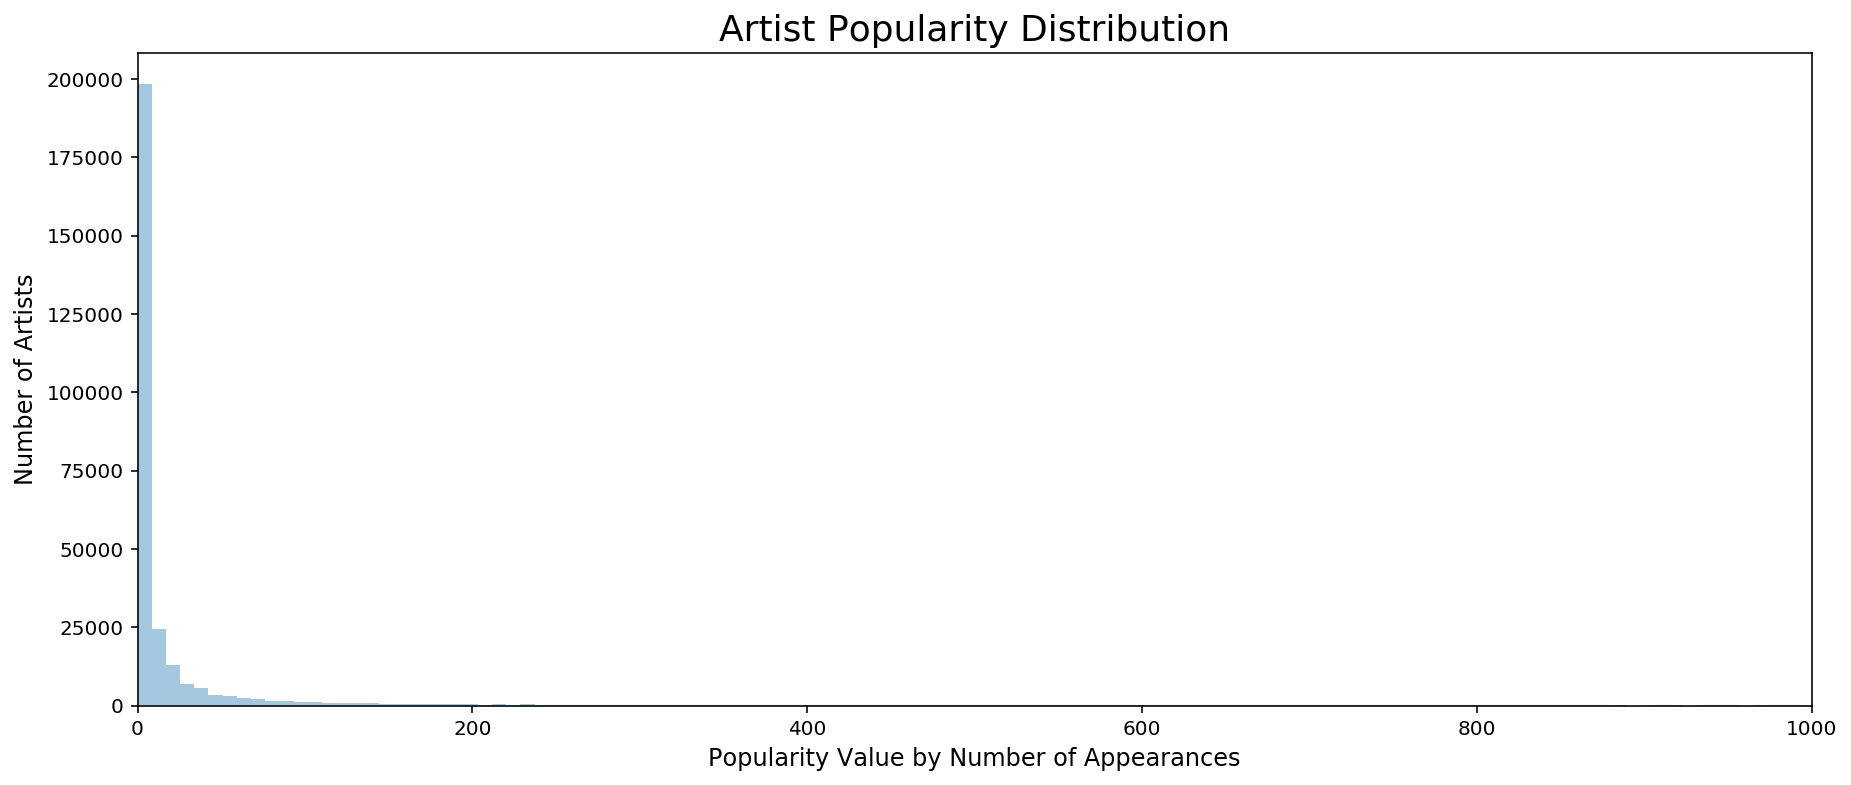

In [21]:
# distribution of artist appearances in playlists
fig, subplot = plt.subplots(figsize=(15,6))
subplot.set_title("Artist Popularity Distribution", fontsize=18)
sns.distplot(df_artist_popularity1['count'].values, bins=100000, ax=subplot, kde=False);
subplot.set_xlabel("Popularity Value by Number of Appearances", fontsize=12)
subplot.set_ylabel("Number of Artists", fontsize=12);
subplot.set_xlim((0,1000))
# start, end = subplot.get_xlim()
# subplot.xaxis.set_ticks(np.arange(0, end, 25))
fig.show()

**NOTE:**
The top 20 are outliers.  75% of artists have 13 or fewer appearances.  The median number of appearances is only 3.  

In [22]:
# Artist Popularity Values
db_artist_popularity = display_time(session.query(Artists.artist_name, Artists.artist_popularity).all)
artist_popularity = pd.DataFrame(db_artist_popularity, columns=['artist', 'popularity']).sort_values(by='popularity', ascending=False).reset_index(drop=True)


Time to Execute: 6.74 seconds


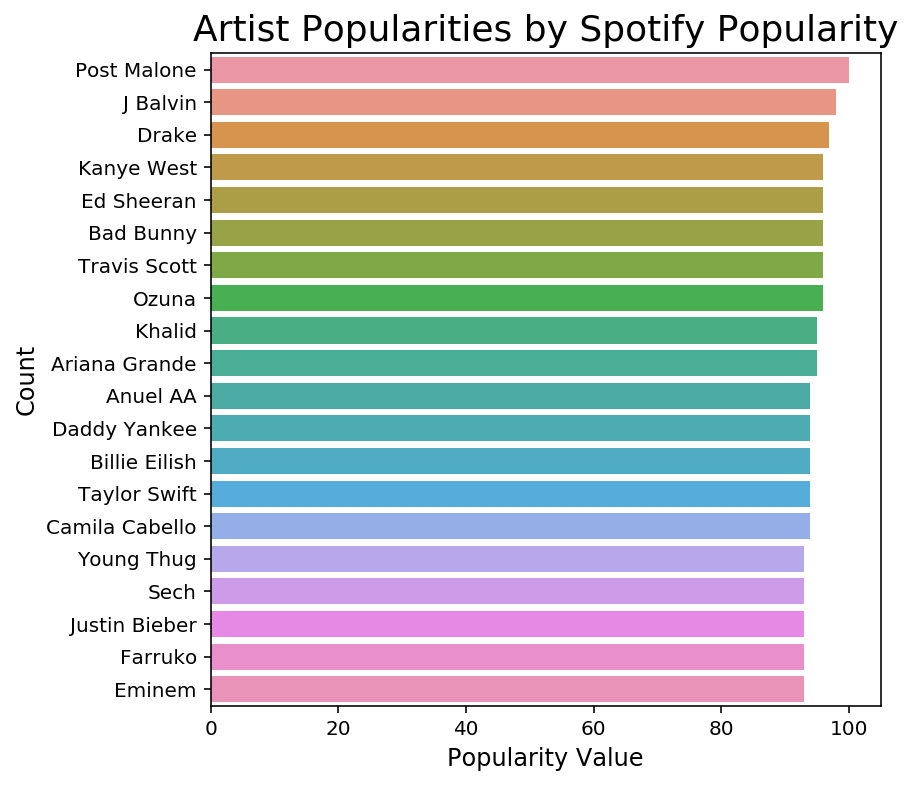

In [23]:
fig, subplot = plt.subplots(figsize=(6,6))
subplot.set_title("Artist Popularities by Spotify Popularity", fontsize=18)

sns.barplot(y=artist_popularity[:20]['artist'],
            x=artist_popularity[:20]['popularity'],
            orient="h", ax=subplot)

subplot.set_xlabel("Popularity Value", fontsize=12)
subplot.set_ylabel("Count", fontsize=12);

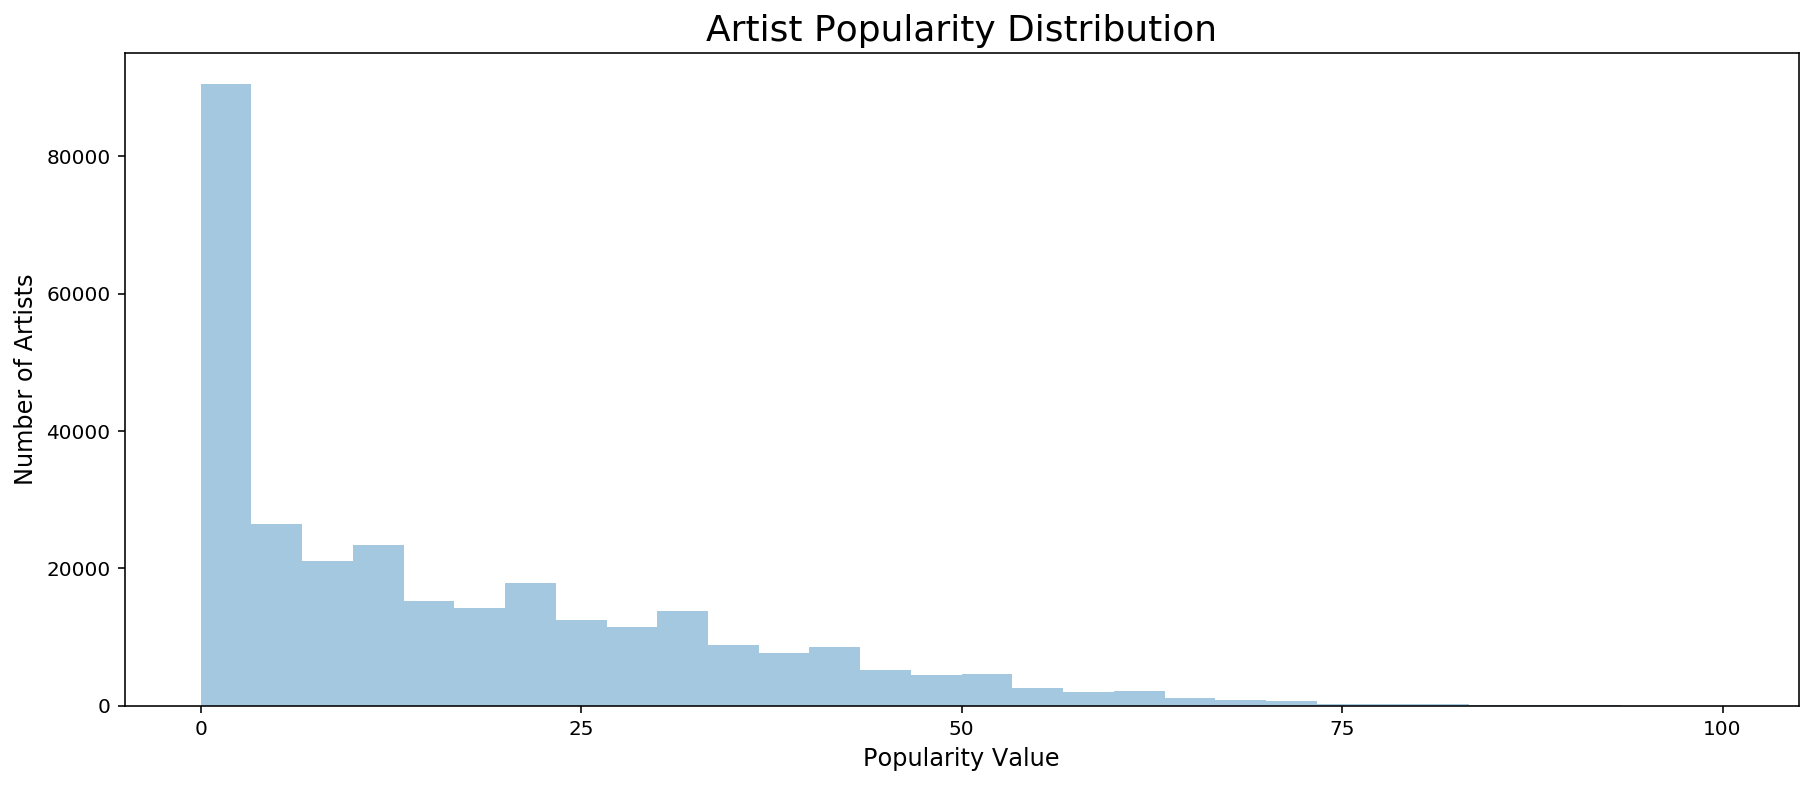

In [24]:
# distribution of Spotify Popularity Values
fig, subplot = plt.subplots(figsize=(15,6))
subplot.set_title("Artist Popularity Distribution", fontsize=18)
sns.distplot(artist_popularity.popularity, bins=30, ax=subplot, kde=False);
subplot.set_xlabel("Popularity Value", fontsize=12)
subplot.set_ylabel("Number of Artists", fontsize=12);

start, end = subplot.get_xlim()
subplot.xaxis.set_ticks(np.arange(0, end, 25))
fig.show()


In [25]:
artist_popularity.describe()

,popularity
count,296014.000000
mean,16.377198
std,16.619688
min,0.000000
25%,2.000000
50%,11.000000
75%,27.000000
max,100.000000


In [26]:
np.median(artist_popularity['popularity'])

11.0

### Note:
A large proportion of artists have a 0 value for Sportify popularity.  75% of artists have a popularity value of 27 or below and the median value is only 11.

### Artist Genres

In [27]:
artist_genres = pd.DataFrame(display_time(session.query(Artists.artist_name, Artists.genres).all))

Time to Execute: 0.46 seconds


In [28]:
artist_genres.head()

,artist_name,genres
0,Jane's Addiction with Body Count,
1,Alive In Wild Paint,dreamo
2,King Eider,"crossover prog,dutch prog"
3,Resorte,"latin alternative,latin metal,latin rock,mexic..."
4,Corey Russell,deep ccm


In [29]:
# create a list of unique genres
genres = np.concatenate([np.array(x.split(',')) for x in artist_genres.genres])
unique_genres = np.unique(genres)
print("Number of genres: {}".format(len(unique_genres)))


Number of genres: 3635


In [30]:
# count per genre
genres_count = pd.DataFrame(unique_genres, columns=['genre'])
genres_count['count'] = pd.Series(np.zeros(len(genres_count), dtype=int))
genres_count.set_index('genre', inplace=True, drop=True)

for g in tqdm(unique_genres, desc='counting genres'):
    genres_count.loc[g] = np.sum(genres==g)

genres_count.sort_values(by='count', inplace=True, ascending=False)

In [31]:
genres_count.head()

,count
genre,
,181365
pop,637
dance pop,594
rock,579
modern rock,525


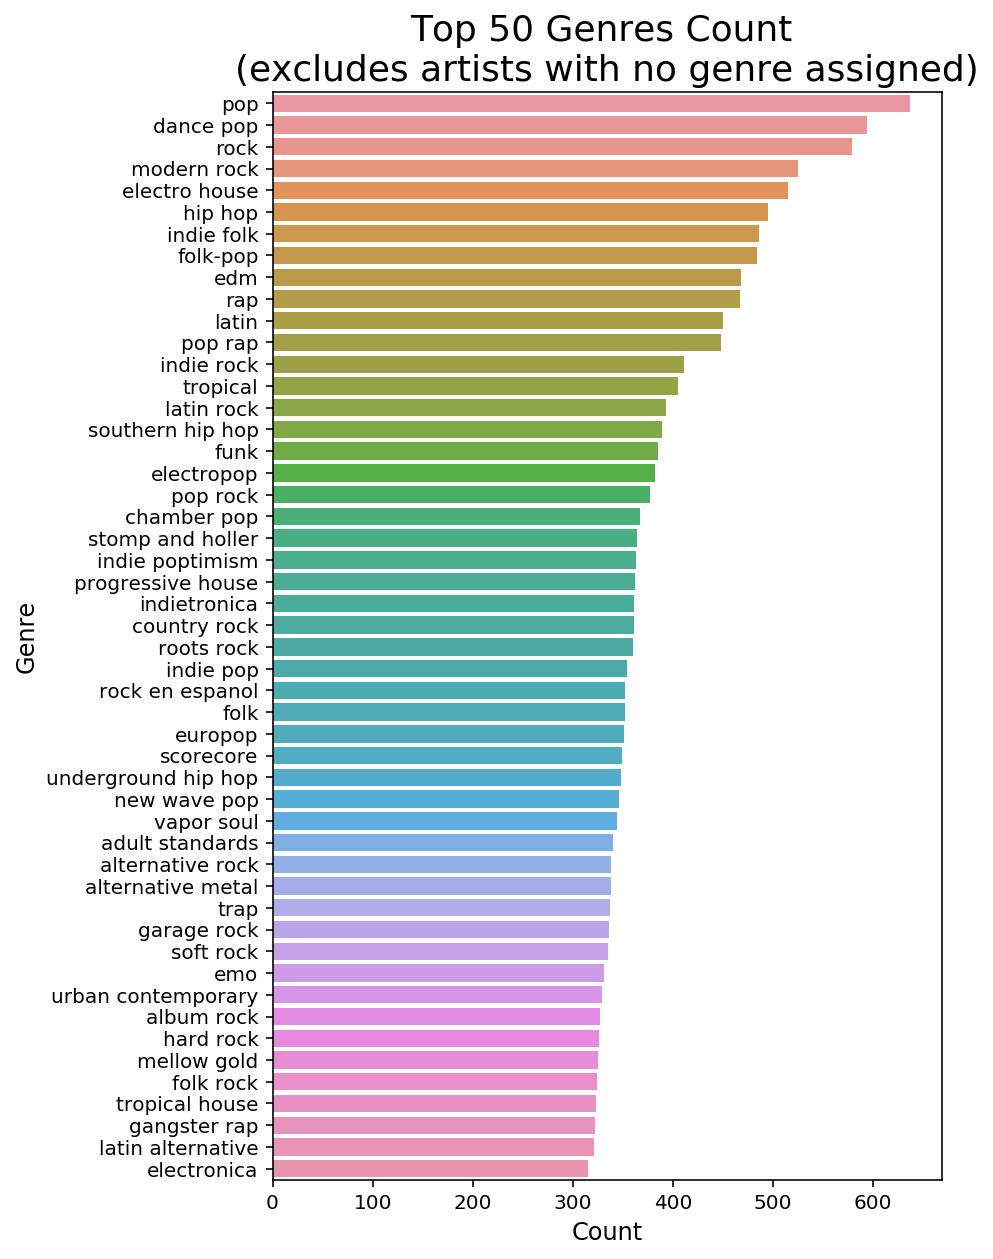

In [32]:
fig, subplot = plt.subplots(figsize=(6,10))
subplot.set_title("Top 50 Genres Count \n(excludes artists with no genre assigned)", fontsize=18)

sns.barplot(y=genres_count[1:51].index,
            x=genres_count[1:51]['count'],
            orient="h", ax=subplot)

subplot.set_xlabel("Count", fontsize=12)
subplot.set_ylabel("Genre", fontsize=12);

**Note:**
181365 of the artists (61%) have no genre assigned.

### Tracks

In [33]:
# fetch all db tracks
db_tracks = display_time(session.query(Tracks).all)

Time to Execute: 80.33 seconds


In [34]:
df_all_tracks = pd.DataFrame([x.__dict__ for x in db_tracks]).drop('_sa_instance_state', axis=1).set_index(['track_uri', 'artist_uri'])


In [35]:
df_all_tracks.describe()


,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_popularity,valence
count,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06,2.261597e+06
mean,3.548610e-01,5.504661e-01,2.474320e+05,5.849420e-01,2.207979e-01,5.261050e+00,2.092522e-01,-9.659046e+00,6.550491e-01,8.935614e-02,1.199810e+02,3.879982e+00,1.267791e+01,4.757893e-01
std,3.543532e-01,1.845284e-01,1.560575e+05,2.659486e-01,3.493907e-01,3.558882e+00,1.899007e-01,5.623792e+00,4.753524e-01,1.152923e-01,2.992131e+01,4.717985e-01,1.391448e+01,2.699183e-01
min,0.000000e+00,0.000000e+00,1.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.230000e-02,4.270000e-01,1.842930e+05,3.890000e-01,0.000000e+00,2.000000e+00,9.580000e-02,-1.190900e+01,0.000000e+00,3.540000e-02,9.693200e+01,4.000000e+00,0.000000e+00,2.470000e-01
50%,2.150000e-01,5.650000e-01,2.252930e+05,6.220000e-01,6.020000e-04,5.000000e+00,1.280000e-01,-8.176000e+00,1.000000e+00,4.710000e-02,1.200060e+02,4.000000e+00,8.000000e+00,4.660000e-01
75%,6.910000e-01,6.890000e-01,2.783070e+05,8.090000e-01,4.210000e-01,8.000000e+00,2.640000e-01,-5.825000e+00,1.000000e+00,8.400000e-02,1.380510e+02,4.000000e+00,2.100000e+01,6.970000e-01
max,9.960000e-01,9.960000e-01,6.047705e+06,1.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00,4.923000e+00,1.000000e+00,9.710000e-01,2.499870e+02,5.000000e+00,8.800000e+01,1.000000e+00


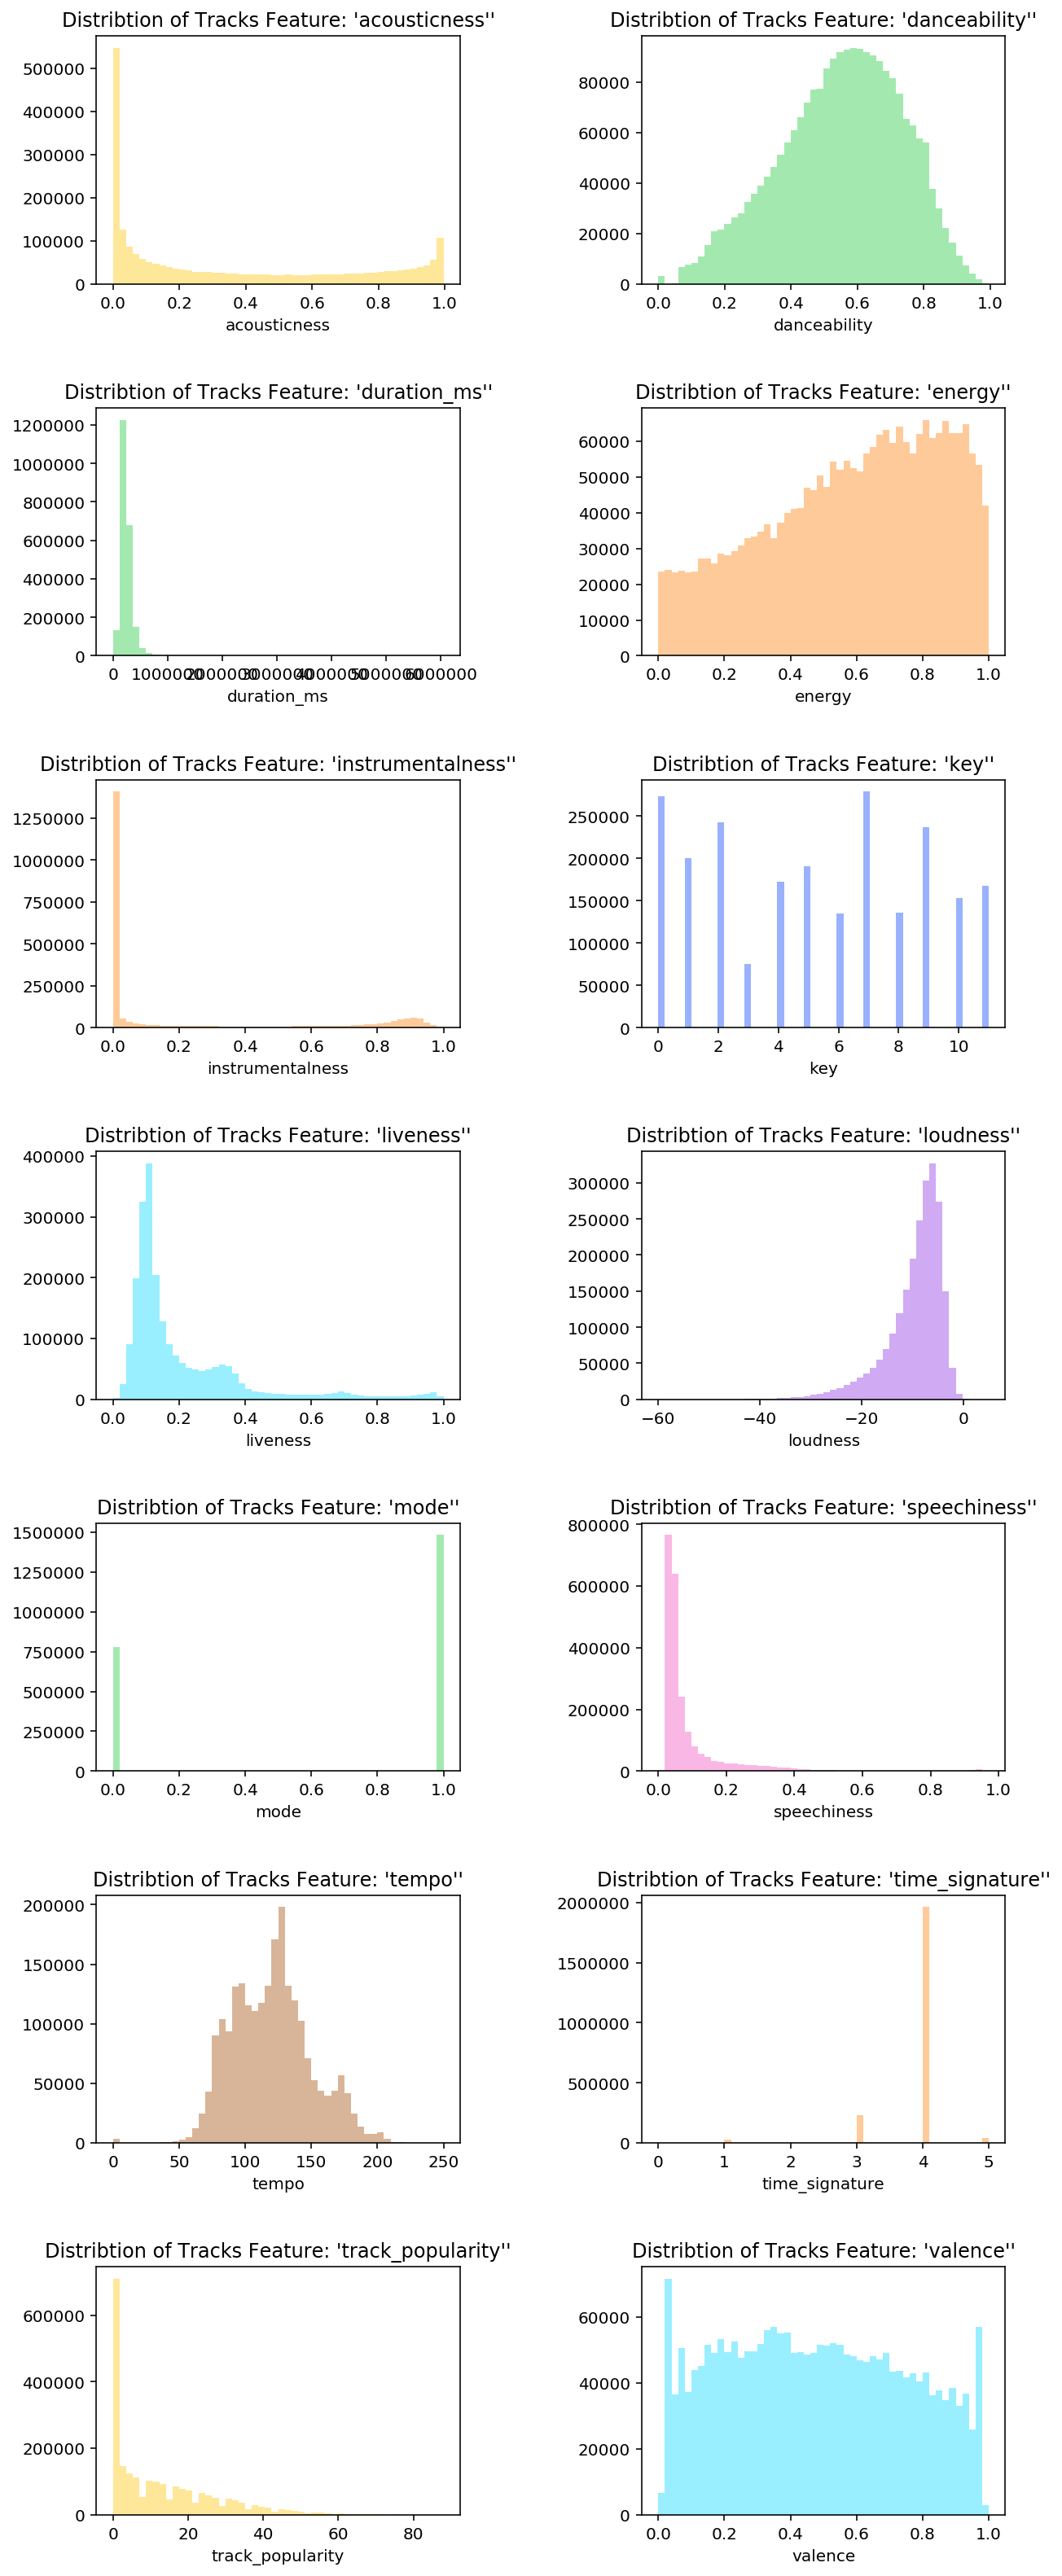

In [36]:
features = df_all_tracks.columns
num_features = len(features)

colors = sns.color_palette("bright", num_features*2)

fig, subplot  = plt.subplots(nrows=int(num_features/2), ncols=2, figsize=(10,len(features)*2))
# fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=.5)

for i, ax in enumerate(np.ravel(subplot)):
    sns.distplot(df_all_tracks[features[i]], kde=False, ax=ax, color=colors[random.randint(0,num_features)])
    ax.set_title("Distribtion of Tracks Feature: '{}''".format(features[i]))

### **Note:**
### The following accoustic features are most useful:
- danceability
- energy
- key
- liveness
- loudness
- speechiness
- tempo
- valence

In [49]:
# Count records that seem to have largely missing information

# Create a counting dataframe
counts = [np.sum(df_all_tracks[f]==0) for f in features]
zero_counts = pd.DataFrame(counts, columns=['count'], index=features)
zero_counts['percentages'] = np.array(counts)/len(df_all_tracks)
zero_counts

,count,percentages
acousticness,870,0.000385
danceability,3133,0.001385
duration_ms,0,0.000000
energy,439,0.000194
instrumentalness,607663,0.268688
key,273848,0.121086
liveness,1084,0.000479
loudness,0,0.000000
mode,780140,0.344951
speechiness,3130,0.001384


**NOTE:**
> Items with a count of zero are either meaningful or are a very small percent of the population.
> Track popularity is not populated in a sufficient number of records to be useful

In [56]:
vector_features= [
    'acousticness',
    'danceability',
    'duration_ms',
    'energy',
    'instrumentalness',
    'key',
    'liveness',
    'loudness',
    'mode',
    'speechiness',
    'tempo',
    'time_signature',
    'valence'
]

In [59]:
def create_vector_frame(df_all_tracks:pd.DataFrame, vector_features:list)->pd.DataFrame:
    
    drop_cols = set(df_all_tracks.index) - set(vector_features)
    
    df = df_all_tracks.drop(drop_cols, axis=1)
    

### Spotify API

In [ ]:
# Get URI for Artist, Track and Album for a song
rv = display_time(session.query(Playlists.track_name, 
                                Playlists.track_uri,
                                Playlists.artist_uri,
                                Playlists.album_uri).filter(Playlists.track_name=="Who Says").distinct().first)

In [ ]:
rv

In [ ]:
# Get URI for Artist, Track and Album for a song
rv = display_time(session.query(Playlists).filter(Playlists.track_name=="Who Says").distinct().first)

In [ ]:
# use Spotify API to get artist genres from uri
get_spotify_data(db_uri=rv.artist_uri, key='genres')

In [ ]:
# use Spotify API to get artist popularity from uri
get_spotify_data(db_uri=rv.artist_uri, key='popularity')

In [ ]:
# use Spotify API to get track popularity from uri
get_spotify_data(db_uri=rv.track_uri, key='popularity')

### Get data using implicit Join between Songs and Audio_Features

In [ ]:
test_track = display_time(session.query(Playlists, Tracks)
                          .filter(Playlists.track_uri==Tracks.track_uri)
                          .distinct()
                          .first)

In [ ]:
for tk in test_track.keys():
    print (tk)
    tk_dict = test_track.__getattribute__(tk).__dict__
    for k,v in tk_dict.items():
        print ("\t{}  :  {}".format(k,v))

In [17]:
# get num playlists that a specified song is in
rv = display_time(session.query(Playlists.playlist_id).filter(Playlists.track_name=="Who Says").count)
rv

Time to Execute: 54.92 seconds


7474

In [255]:
# get number of unique artists
rv = display_time(session.query(Playlists.artist_name).distinct().count)
rv

2019-10-23 11:05:11,137 INFO sqlalchemy.engine.base.Engine SELECT count(*) AS count_1 
FROM (SELECT DISTINCT songs.artist_name AS songs_artist_name 
FROM songs) AS anon_1
2019-10-23 11:05:11,138 INFO sqlalchemy.engine.base.Engine ()
Time to Execute: 46.02 seconds


287740

In [257]:
# get all songs from a particular artist
rv = display_time(session.query(Playlists.track_name).filter(Playlists.artist_name=="John Mayer").distinct().all)
len(rv)

2019-10-23 11:08:02,671 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT songs.track_name AS songs_track_name 
FROM songs 
WHERE songs.artist_name = ?
2019-10-23 11:08:02,672 INFO sqlalchemy.engine.base.Engine ('John Mayer',)
Time to Execute: 6.6 seconds


206

In [268]:
# get all playlists that an artist appears in
rv = display_time(session.query(Playlists.playlist_id).filter(Playlists.artist_name=="John Mayer").distinct().all)
len(rv)

2019-10-23 11:14:48,562 INFO sqlalchemy.engine.base.Engine SELECT DISTINCT songs.playlist_id AS songs_playlist_id 
FROM songs 
WHERE songs.artist_name = ?
2019-10-23 11:14:48,563 INFO sqlalchemy.engine.base.Engine ('John Mayer',)
Time to Execute: 6.87 seconds


48110

In [304]:
# get all songs in playlists where an artist appears in
subq = session.query(Playlists.playlist_id).filter(Playlists.artist_name=="John Mayer").distinct().subquery()
rv = display_time(session.query(Playlists.playlist_id, Playlists.artist_name, Songs.track_name).filter(Playlists.playlist_id.in_(subq)).distinct().all)
len(rv)

Time to Execute: 81.7 seconds


4426419

In [305]:
# get all songs in playlists where a song appears in
subq = session.query(Playlists.playlist_id).filter(Playlists.track_name=="Who Says").distinct().subquery()
rv = display_time(session.query(Playlists.playlist_id, Playlists.artist_name, Playlists.track_name).filter(Playlists.playlist_id.in_(subq)).distinct().all)
len(rv)

Time to Execute: 98.73 seconds


779527

In [309]:
rv[3]

(77, 'The Maine', 'Everything I Ask For')

In [264]:
# get all songs from playlists where an artist is in the list
rv = display_time(session.query(Playlists.playlist_id, Playlists.artist_name, Playlists.track_name).filter(Playlists.artist_name=="John Mayer").distinct().all)
len(rv)

(18, 'John Mayer', 'Stop This Train - Live at the Nokia Theatre')

## EDA

In [84]:
df_counts_agg[df_counts_agg.playlist_id==df_counts_agg.playlist_id.max()]

,playlist_id
song_count,
20,15028


In [93]:
# df_counts_agg.sort_values(by="playlist_id", ascending=False)
df_counts_agg[df_counts_agg.index<50].sum()

playlist_id    502676
dtype: int64

In [ ]:
connection.close()